In [15]:
import librosa
import soundfile as sf
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import cv2 #3.3.0 version
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

G:\ANACONDA3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


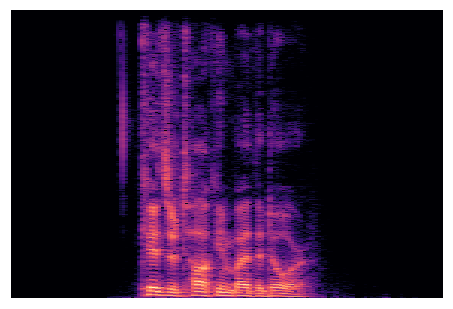

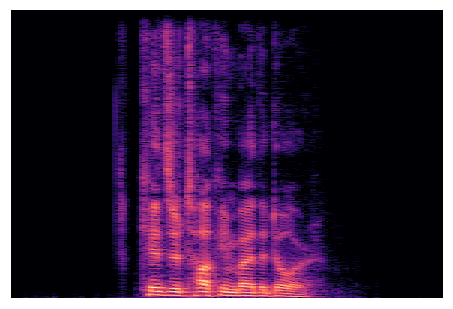

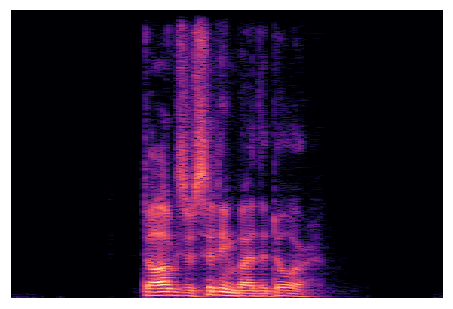

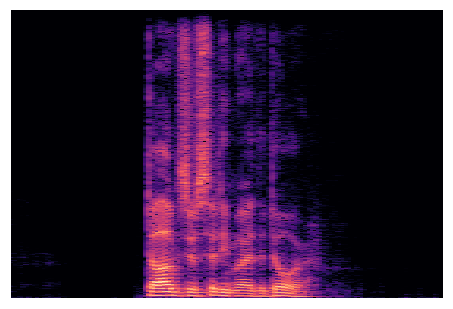

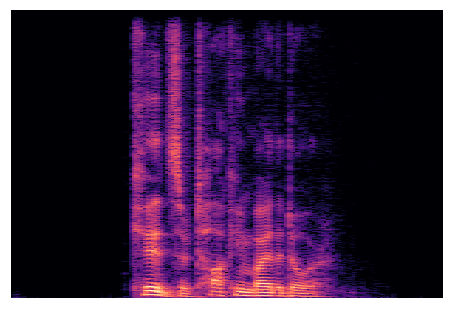

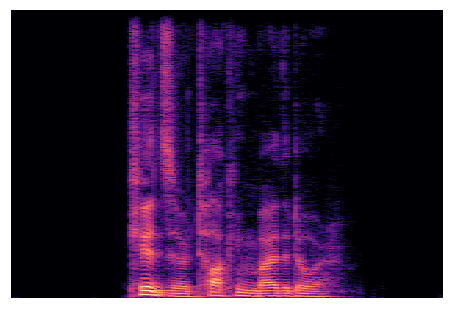

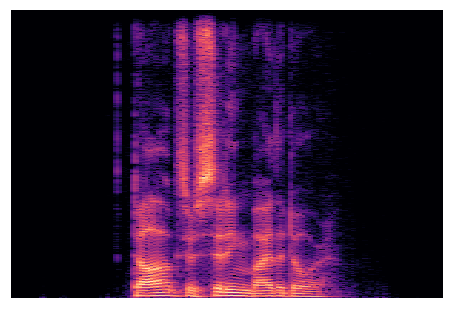

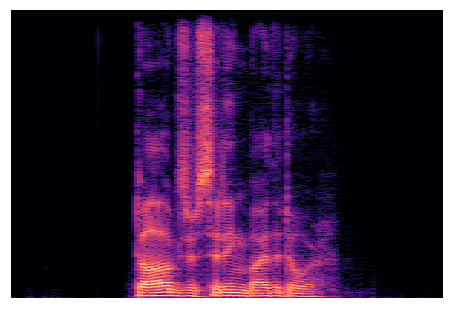

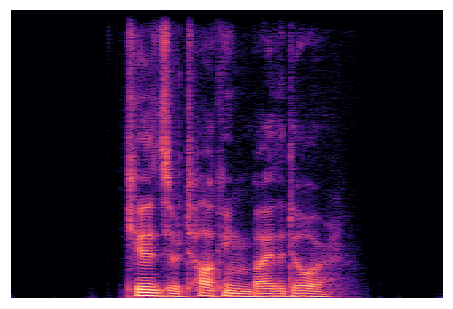

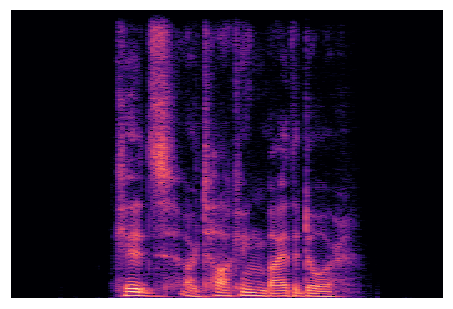

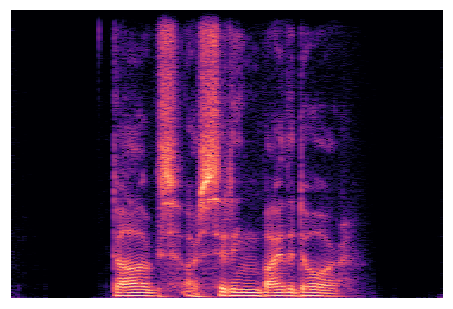

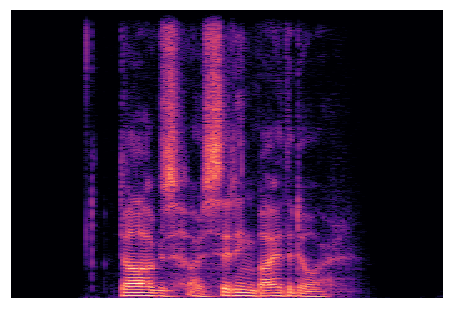

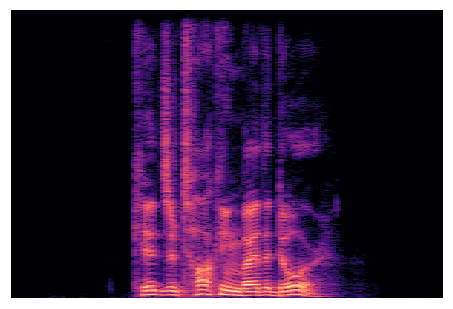

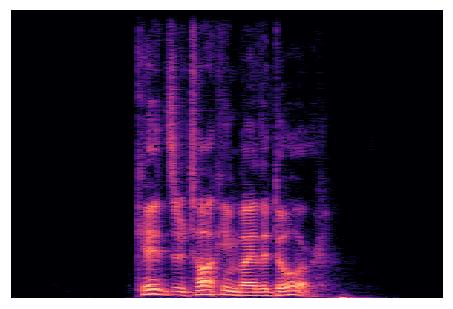

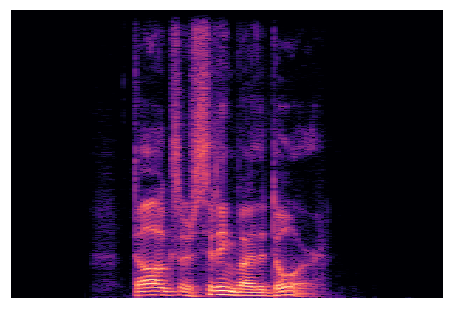

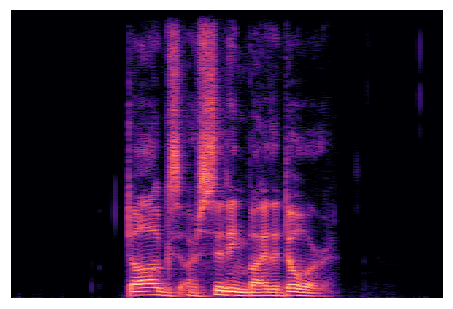

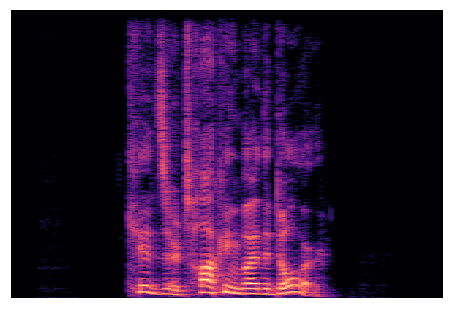

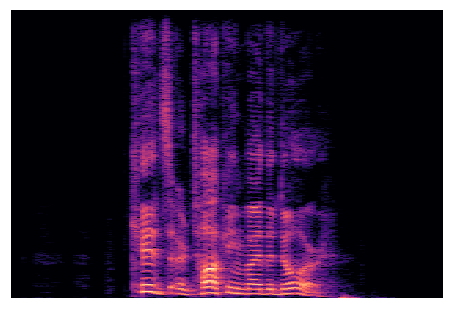

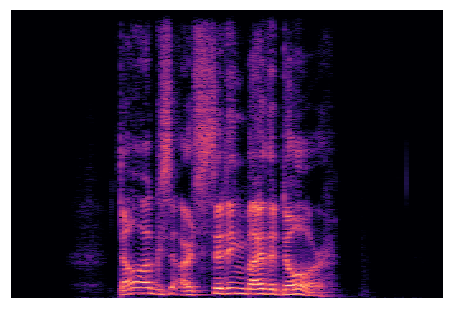

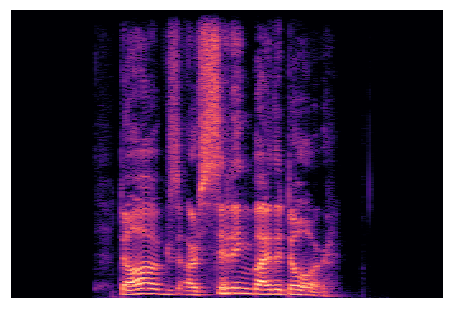

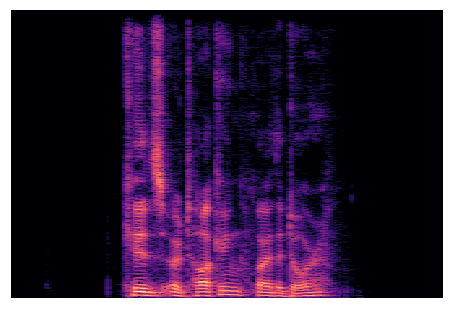

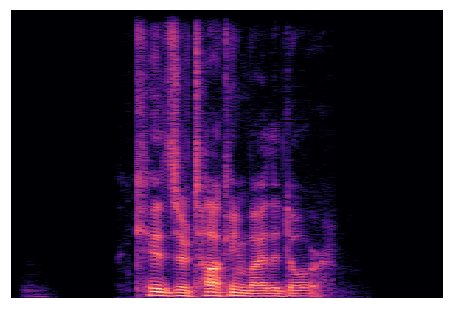

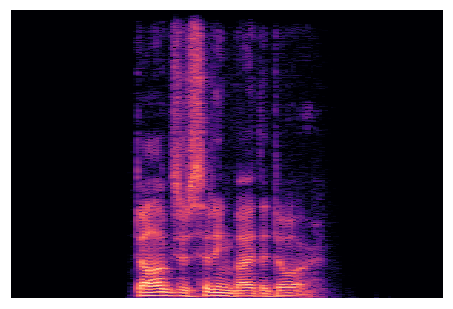

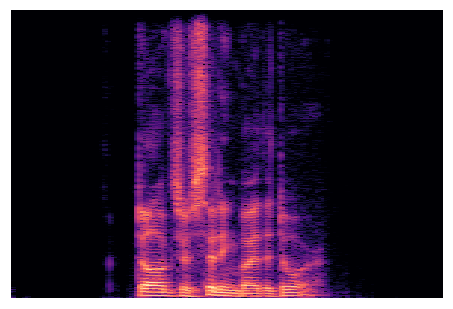

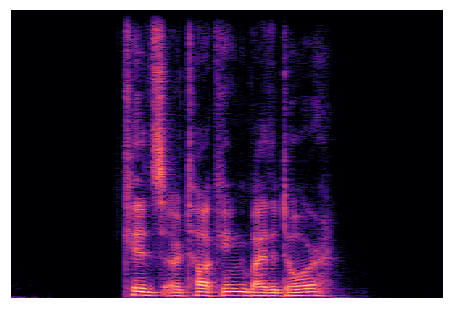

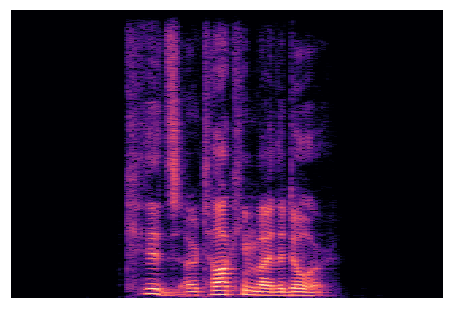

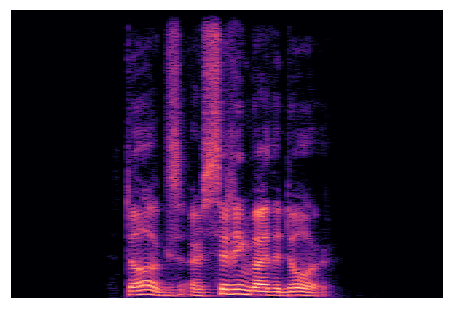

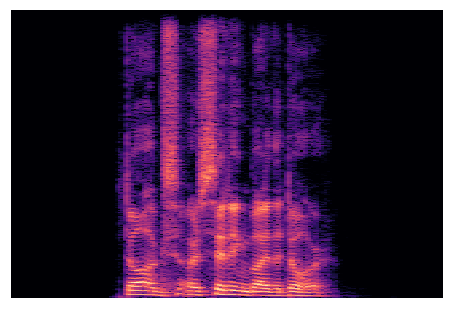

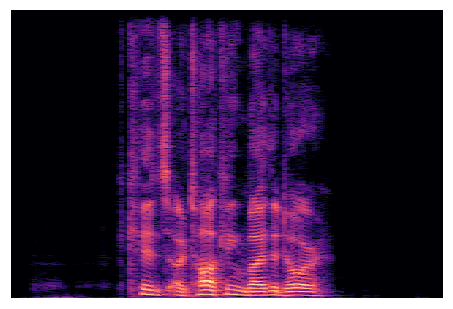

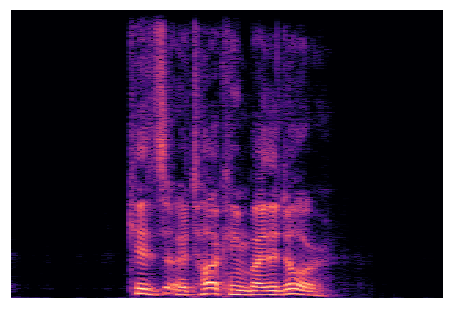

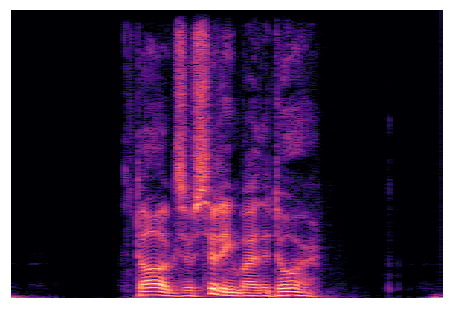

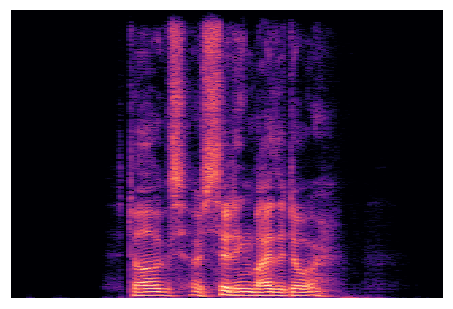

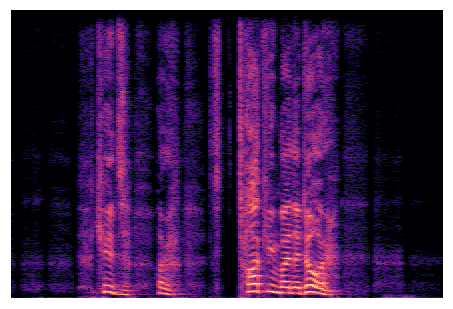

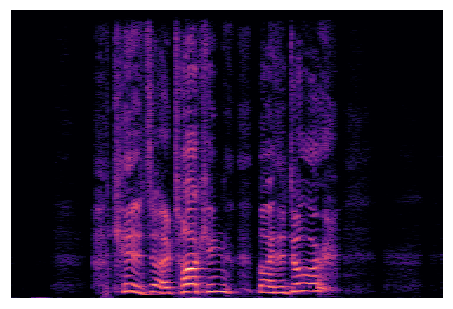

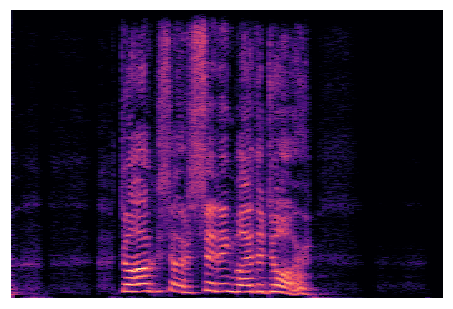

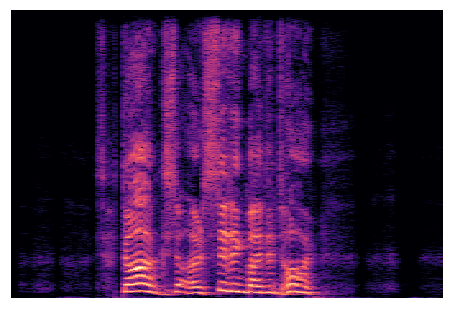

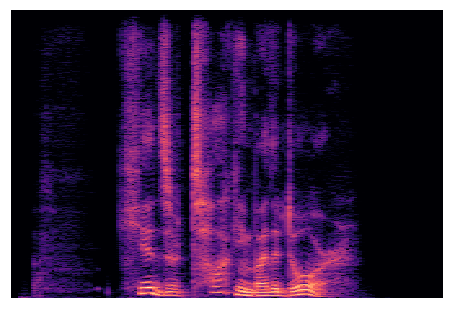

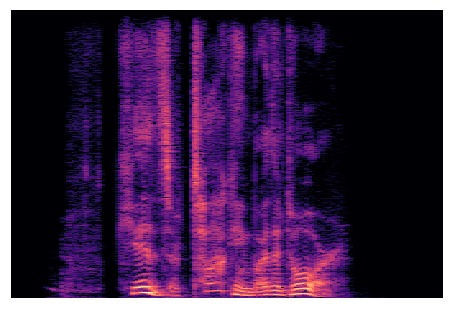

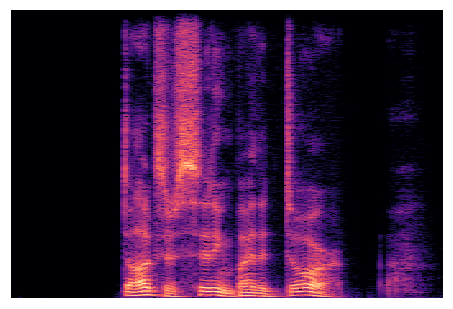

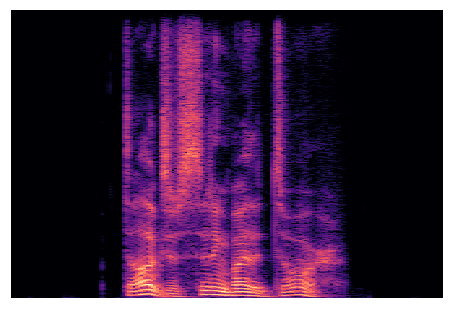

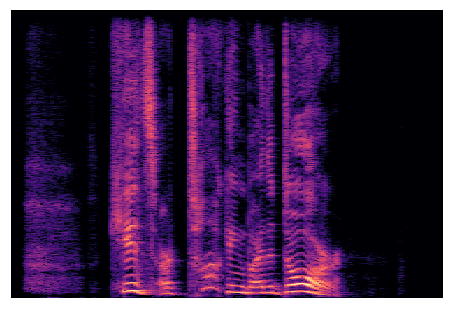

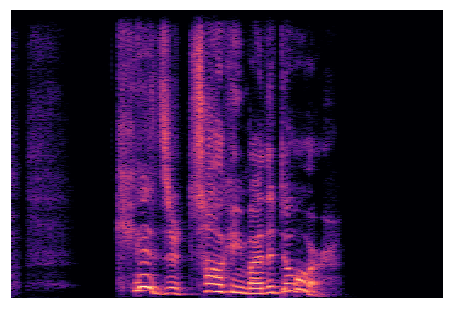

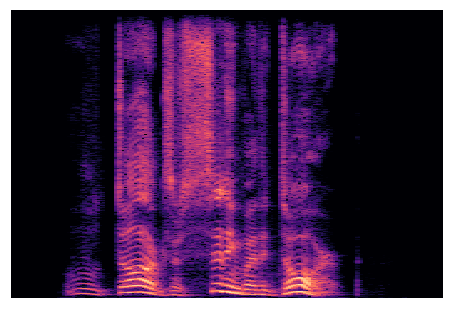

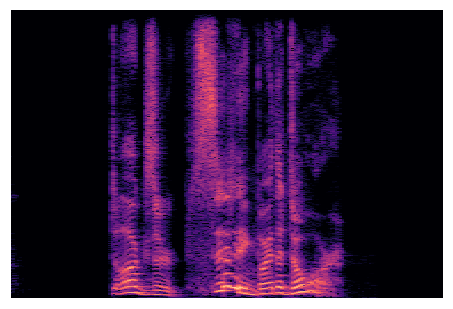

In [17]:
#To generate Spectogram dataset of given sound files

emotions={

  '01':'neutral',

  '02':'calm',

  '03':'happy',

  '04':'sad',

  '05':'angry',

  '06':'fearful',

  '07':'disgust',

  '08':'surprised'

}

#Emotions to observe

observed_emotions=['neutral','calm', 'happy', 'fearful','sad','disgust']

for file in glob.glob(r"C:\Users\PRIYANSHU PANDEY\Desktop\Stuti\Ravdess small sample datase\\Actor_01\\*.wav"):

        try:

            file_name = os.path.basename(file)
            emotion = emotions[file_name.split("-")[2]]
            if emotion not in observed_emotions:
                continue

            X, sr = librosa.load(file)
            X = librosa.stft(X)
            Xdb = librosa.amplitude_to_db(abs(X),ref=np.max)
            fig,ax = plt.subplots(1)
            fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
            ax.axis('tight')
            ax.axis('off')
            librosa.display.specshow(Xdb, sr=sr) 
            fig.savefig(r'C:\Users\PRIYANSHU PANDEY\Desktop\Stuti\\Dataset//'+str(file_name.split(".")[0])+'.png', dpi=100, frameon='false')

        except ValueError:
            continue

In [2]:
# Before this Separate the spectogram images in to train and test folder by own

def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" 
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat,0)
            if img is not None:
                category.append(img)
        images[filename] = category
    return images
images = load_images_from_folder(r"C:\Users\PRIYANSHU PANDEY\Desktop\Stuti\Dataset\train")  # take all images category by category 
test = load_images_from_folder(r"C:\Users\PRIYANSHU PANDEY\Desktop\Stuti\Dataset\test")  # take test images 
print(images,test)

{'03-01-03-01-01-01-01.png': [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [54, 54, 54, ..., 41, 41, 41],
       [ 0,  0,  0, ..., 20, 20, 20],
       [ 0,  0,  0, ..., 30, 30, 30]], dtype=uint8), array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [36, 36, 36, ..., 11, 11, 11],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 3,  3,  3, ...,  0,  0,  0]], dtype=uint8), array([[ 0,  0,  0, ..

In [3]:
# Used SIFT algorithm for feature detection and to describe local features in images.

def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
           
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

sifts = sift_features(images) 
descriptor_list = sifts[0] 
all_bovw_feature = sifts[1] 
test_bovw_feature = sift_features(test)[1] 

In [72]:
# print(len(descriptor_list))
# print(len(all_bovw_feature))
# print(len(test_bovw_feature))
# sifts[1]

31


In [76]:
# It takes too much time, for ex 2 cluster takes 7-8 mint.

def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
visual_words = kmeans(50, descriptor_list) 

In [77]:
len(visual_words)

50

In [78]:
# Feature vectors for geting bag of visual words for train and test image data.

def find_index(vector1,vector2):
    distanceList = {}
    for ndx, val in enumerate(vector2):
        distanceD = distance.euclidean(vector1,val)
        distanceList[ndx] = distanceD
    index = min(distanceList, key=lambda k: distanceList[k])
    return index

def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
bovw_train = image_class(all_bovw_feature, visual_words) 
bovw_test = image_class(test_bovw_feature, visual_words) 

In [79]:
len(bovw_test)

13

In [80]:
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] 
        for tst in test_val:
            predict_start = 0
            minimum = 0
            key = "a" 
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
    return [num_test, correct_predict, class_based]
    
results_bowl = knn(bovw_train, bovw_test)

In [81]:
results_bowl[2]

{'03-01-06-01-02-02-01.png': [0, 13],
 '03-01-06-02-01-01-01.png': [0, 13],
 '03-01-06-02-01-02-01.png': [0, 13],
 '03-01-06-02-02-01-01.png': [0, 13],
 '03-01-06-02-02-02-01.png': [0, 13],
 '03-01-07-01-01-01-01.png': [0, 13],
 '03-01-07-01-01-02-01.png': [0, 13],
 '03-01-07-01-02-01-01.png': [0, 13],
 '03-01-07-01-02-02-01.png': [0, 13],
 '03-01-07-02-01-01-01.png': [0, 13],
 '03-01-07-02-01-02-01.png': [0, 13],
 '03-01-07-02-02-01-01.png': [0, 13],
 '03-01-07-02-02-02-01.png': [0, 13]}

In [82]:
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
accuracy(results_bowl) 

Average accuracy: %0.0

Class based accuracies: 

03-01-07-01-01-01-01.png : %0.0
03-01-06-02-02-02-01.png : %0.0
03-01-07-01-02-01-01.png : %0.0
03-01-07-02-02-01-01.png : %0.0
03-01-07-01-02-02-01.png : %0.0
03-01-07-02-01-01-01.png : %0.0
03-01-06-01-02-02-01.png : %0.0
03-01-07-01-01-02-01.png : %0.0
03-01-06-02-01-02-01.png : %0.0
03-01-06-02-01-01-01.png : %0.0
03-01-07-02-01-02-01.png : %0.0
03-01-07-02-02-02-01.png : %0.0
03-01-06-02-02-01-01.png : %0.0
